# Stock Price Predictor

## Requeriments

Importing the necessary libraries.

In [1]:
# Display inline matplotlib plots with IPython
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

import warnings
import os

import math
import datetime
import pytz
import requests
import pickle

import numpy as np
import pandas as pd

from pandas.io.json import json_normalize

import matplotlib.pyplot as plt

from sklearn.decomposition import PCA


# Linear Regression
from sklearn.linear_model import LinearRegression

# Arima
from pyramid.arima import auto_arima

# Facebook's Prophet
from fbprophet import Prophet

# Long Short Term Memory
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


from tools.visuals import pca_results

# Makes Keras picklable
from tools.make_keras_picklable import make_keras_picklable
make_keras_picklable()

/usr/local/lib/python3.5/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a package name collision with the
    Pyramid web framework. For more information, see Issue #34:
    
        https://github.com/tgsmith61591/pyramid/issues/34
        
    The package will subsequently be installable via the name 'pmdarima'; the
    only functional change to the user will be the import name. All imports
    from 'pyramid' will change to 'pmdarima'.
    
  """, UserWarning)
/usr/local/lib/python3.5/dist-packages/pyramid/_config.py:59: UserWarning: The Pyramid cache (/root/.pyramid-arima-cache) has grown to 746,549,478 bytes. Consider cleaning out old ARIMA models or increasing the max cache bytes with 'PYRAMID_ARIMA_CACHE_WARN_SIZE' (currently 100,000,000 bytes) to avoid this warning in the future.
  UserWarning)
Using TensorFlow backend.


Some useful functions to support the constructions in this project.

In [2]:
def expand_date_in_dataframe(df):
    """
    It breaks the date attibute (assuming it's a datetime) of a dataframe in more fileds
    for year, month, day, week, day of week, day of year and timestamp.
    """
    df['year'] = df.date.dt.year
    df['month'] = df.date.dt.month
    df['day'] = df.date.dt.day
    df['week'] = df.date.dt.week
    df['dayofweek'] = df.date.dt.dayofweek
    df['dayofyear'] = df.date.dt.dayofyear
    df['timestamp'] = df.date.values.astype(np.int64)


def str_to_datetime(date):
    """
    Converts a string into a datetime.

    :param str date: The string representation in the format 'yyyy-mm-dd' of the date to convert.
    :return: The resulting datetime.
    :rtype: datetime.datetime
    """
    return datetime.datetime.strptime(date, '%Y-%m-%d')


def datetime_array_to_dataframe(days):
    """
    Gets a dataframe from an array of dates.

    :param list[datetime.datetime] date: The array of dates.
    :return: The dataframe.
    :rtype: pandas.DataFrame
    """
    return pd.DataFrame({'date': days})

# Dataset

In [3]:
class Dataset:
    """
    This class is used to manage the dataset that contains the hsitoric stock prices
    for the companies contemplated in the Dow Jones Industrial Average.
    """

    """ Ticker symbols of the companies contemplated in the  Dow Jones Industrial Average. """
    DJIA_TICKERS = [
        'BA',   'PFE', 'MCD', 'WMT', 'KO',   'MRK',  'HD',   'V',   'JNJ',  'VZ',
        'CSCO', 'AXP', 'TRV', 'DIS', 'MSFT', 'UNH',  'DWDP', 'CAT', 'AAPL', 'UTX',
        'MMM',  'JPM', 'IBM', 'GS',  'XOM',  'INTC', 'NKE',  'CVX', 'PG',   'WBA' ]

    """ This is the symbol used by the actual average, i.e. the Dow Jones Industrial Average. """
    DJIA_SYMBOL = 'DIA'

    """ Value used to get the historical data from 5 years ago. """
    HIST_5Y = '5y'

    """ Value used to get the historical data from 1 year ago. """
    HIST_1Y = '1y'

    """ Value used to get the historical data from 1 month ago. """
    HIST_1M = '1m'

    """
    This is the template to create the URL to extract historical stock prices
    from the IEX API.
    """
    __IEX_API_URL_TEMPLATE = 'https://api.iextrading.com/1.0/stock/{}/chart/{}'


    def __init__(self, dataframe=None):
        """
        The constructor of Dataset.

        :param pandas.DataFrame df: The dataframe containing stock price historical records,
                                    which will be actual data.
        """
        self.dataframe = dataframe


    @staticmethod
    def __preprocess_dataframe(df):
        """
        Pre-processes a dataframe containing stock price historical records (from IEX)
        by removing the columns that are not useful to make future predictions
        and expanding the date in more columns.

        :param pandas.DataFrame df: The dataframe containing stock price historical records.
        :return: The pre-processed dataframe.
        :rtype: pandas.DataFrame
        """
        formated_df = df.drop(['label',
                               'change', 'changeOverTime', 'changePercent',
                               'high', 'low', 'open',
                               'unadjustedVolume', 'volume', 'vwap'],
                              axis=1)

        expand_date_in_dataframe(formated_df)
        return formated_df


    @staticmethod
    def __get_dataframe_for_ticker(ticker_symbol, hist_period):
        """
        Retrieves the historic prices for a particuler stock from the data source,
        i.e. the IEX API.

        :param str ticker_symbol: The ticker symbol or symbols to filter the data.
        :param str hist_period: The period to retrieve historical records,
                                p.e '5y' for 5 years, '1y' for 1 year, '1m' for 1 month, etc.
        :return: The dataframe containing the historic prices.
        :rtype: pandas.DataFrame
        """
        # Getting the historic records from IEX
        r = requests.get(url=Dataset.__IEX_API_URL_TEMPLATE.format(ticker_symbol.lower(), hist_period))
        df = json_normalize(r.json())

        # Converting the date to a datetime
        df.date = pd.to_datetime(df.date, format='%Y-%m-%d')

        # Adding the ticker symbol as a new column
        df.insert(loc=0, column='symbol', value=ticker_symbol)

        return Dataset.__preprocess_dataframe(df)


    @staticmethod
    def __get_djia_dataframe(hist_period):
        """
        Gets a dataframe containing historic prices for stocks in the Dow Jones Industrial Average.

        :param str hist_period: The period to retrieve historical records,
                                p.e '5y' for 5 years, '1y' for 1 year, '1m' for 1 month, etc.
        :return: The dataframe containing the historic prices.
        :rtype: pandas.DataFrame
        """
        # Getting the historic records of the average
        df = Dataset.__get_dataframe_for_ticker(Dataset.DJIA_SYMBOL, hist_period)

        # Retrieves the historic records for each one of the ticker symbols in the
        # Dow Jones Industrial Average
        for ticker_symbol in Dataset.DJIA_TICKERS:
            df = df.append(Dataset.__get_dataframe_for_ticker(ticker_symbol, hist_period))

        return df


    @staticmethod
    def __update_djia_dataframe(df):
        """
        Updates a dataframe containing historic prices for stocks in the Dow Jones Industrial Average,
        by retrieving the most recent records from the information source.

        :param pandas.DataFrame hist_period: The dataframe containing stock price historical records.
        :return: The dataframe containing the historic prices.
        :rtype: pandas.DataFrame
        """

        # Getting the amount of days that need to be updated
        last_recorded_day = max(df.date)
        today = datetime.datetime.now()
        days_to_update = (today - last_recorded_day).days

        # Deciding the historic period to request to the source according to the days that
        # need to be updated
        hist_period = Dataset.HIST_5Y
        if days_to_update < 1:
            return df
        elif days_to_update < 28:
            hist_period = Dataset.HIST_1M
        elif days_to_update < 365:
            hist_period = Dataset.HIST_1Y

        # Getting the data frame containing the missing records
        last_df = Dataset.__get_djia_dataframe(hist_period)

        # Appending the missing records, dropping the duplicates and returning
        return df.append(last_df).drop_duplicates(['symbol', 'date'], keep='last')


    @staticmethod
    def loadDatasetFromFile(file_name):
        """
        Loads the dataset from a file where data was previously stored.

        :param str file_name: The name of the file to load the data from. 
        """
        with open(file_name, 'rb') as fp:
            return Dataset(pickle.load(fp))


    def saveDataToFile(self, file_name=None):
        """
        Saves the current dataset to a file.

        :param file_name: The name of the file to save the data,
                          if None the data is saved to a file in the 'data' directory
                          using a name of the form 'djia_yyyymmdd-yyyymmdd.pkl'
                          with the minimum and maximum recorded dates. 
        :type file_name: str or None
        :return: The name of the file used to store the data.
        :rtype: str
        """
        if file_name is None:
            file_name = os.path.join(
                'data',
                'djia_{:%Y%m%d}-{:%Y%m%d}.pkl'.format(min(self.dataframe.date), max(self.dataframe.date)))

        with open(file_name, 'wb') as fp:
            pickle.dump(self.dataframe, fp)

        return file_name


    @staticmethod
    def createDataset(hist_period=HIST_5Y):
        """
        Creates a dataset with brand new data,
        by default it retrieves historical records from the last 5 years.

        :param str hist_period: The period to retrieve historical records, 5 years ('5y') by default.
        :return: The new dataset.
        :rtype: Dataset
        """
        return Dataset(Dataset.__get_djia_dataframe(hist_period))


    def updateData(self):
        """
        Updates the dataset by getting the most recent history records from the source.
        Note: This method is intended to be run periodicaly in order to keep the dataset up to date.
        """
        self.dataframe = Dataset.__update_djia_dataframe(self.dataframe)


    def getDataframe(self, ticker_symbol=None, from_date=None, to_date=None):
        """
        Gets a dataframe containing a subset of the records of the current dataset,
        which is obtained by filtering by a ticker symbol or list (array) of ticker symbols
        and/or a date range.

        :param ticker_symbol: The ticker symbol or symbols to filter the data.
        :type ticker_symbol: str or list[str] or None
        :param from_date: The minimum date to appear in the records of the subset.
        :type from_date: datetime.datetime or None
        :param to_date: The maximum date to appear in the records of the subset.
        :type to_date: datetime.datetime or None
        :return: The dataframe with the subset resulted of filtering the dataset.
        :rtype: pandas.DataFrame
        """
        df = self.dataframe

        if ticker_symbol is not None:
            if isinstance(ticker_symbol, str): # If ticker_symbol symbol is a string
                df = df.query("symbol == '{}'".format(ticker_symbol))
            elif isinstance(ticker_symbol, list): # If ticker_symbol symbol is an array
                # Creates a query expression as a sequence of ORs
                ticker_symbol_query = None
                for t in ticker_symbol:
                    ticker_symbol_exp = "symbol == '{}'".format(t)
                    if ticker_symbol_query is None:
                        ticker_symbol_query = ticker_symbol_exp
                    else:
                        ticker_symbol_query += "or " + ticker_symbol_exp
                df = df.query(ticker_symbol_query)

        if from_date is not None:
            df = df.query("date >= '{}'".format(from_date))

        if to_date is not None:
            df = df.query("date <= '{}'".format(to_date))

        return df


    
    def getSubset(self, ticker_symbol=None, from_date=None, to_date=None):
        """
        Gets a subset of the current dataset filtered 
        by a ticker symbol or list (array) of ticker symbols and/or a date range.

        :param ticker_symbol: The ticker symbol or symbols to filter the data.
        :type ticker_symbol: str or list[str] or None
        :param from_date: The minimum date to appear in the records of the subset.
        :type from_date: datetime.datetime or None
        :param to_date: The maximum date to appear in the records of the subset.
        :type to_date: datetime.datetime or None
        :return: The subset resulted of filtering the dataset.
        :rtype: Dataset
        """
        df = self.getDataframe(ticker_symbol=ticker_symbol, from_date=from_date, to_date=to_date)
        return Dataset(df)

## Exploration and visualization

In [ ]:
ds = Dataset.createDataset()
dataset_filename = ds.saveDataToFile()
print('Dataset saved in file: {}'.format(dataset_filename))

In [4]:
dataset_filename = os.path.join('data', 'djia_20140324-20190322.pkl')
ds = Dataset.loadDatasetFromFile(dataset_filename)
#ds.updateData()

In [5]:
plotting_y_value = math.ceil(max(ds.dataframe.close) / 50) * 50

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


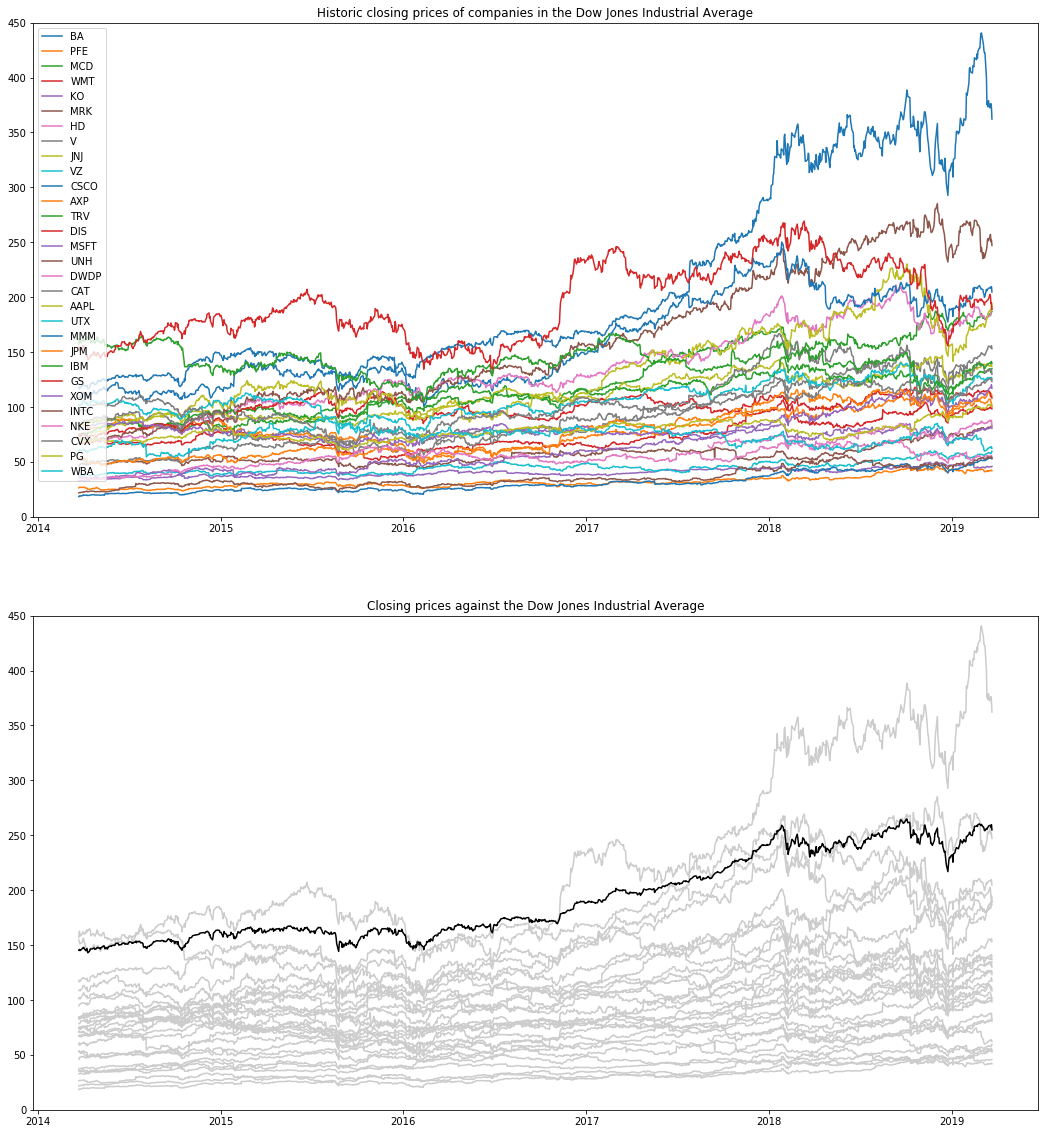

In [6]:
dia_df = ds.getDataframe(ticker_symbol=Dataset.DJIA_SYMBOL)

fig = plt.figure(figsize=(18, 20))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

for tkr in Dataset.DJIA_TICKERS:
    df = ds.getDataframe(ticker_symbol=tkr)
    ax1.plot(df.date, df.close, label=tkr)
ax1.set_title('Historic closing prices of companies in the Dow Jones Industrial Average')
ax1.legend()
ax1.set_autoscale_on(False)
ax1.set_ylim([0, plotting_y_value])

for tkr in Dataset.DJIA_TICKERS:
    df = ds.getDataframe(ticker_symbol=tkr)
    ax2.plot(df.date, df.close, color=(0.8, 0.8, 0.8))
ax2.plot(dia_df.date, dia_df.close, label=Dataset.DJIA_SYMBOL, color='black')
ax2.set_title('Closing prices against the Dow Jones Industrial Average')
ax2.set_autoscale_on(False)
ax2.set_ylim([0, plotting_y_value])

plt.show()

[]

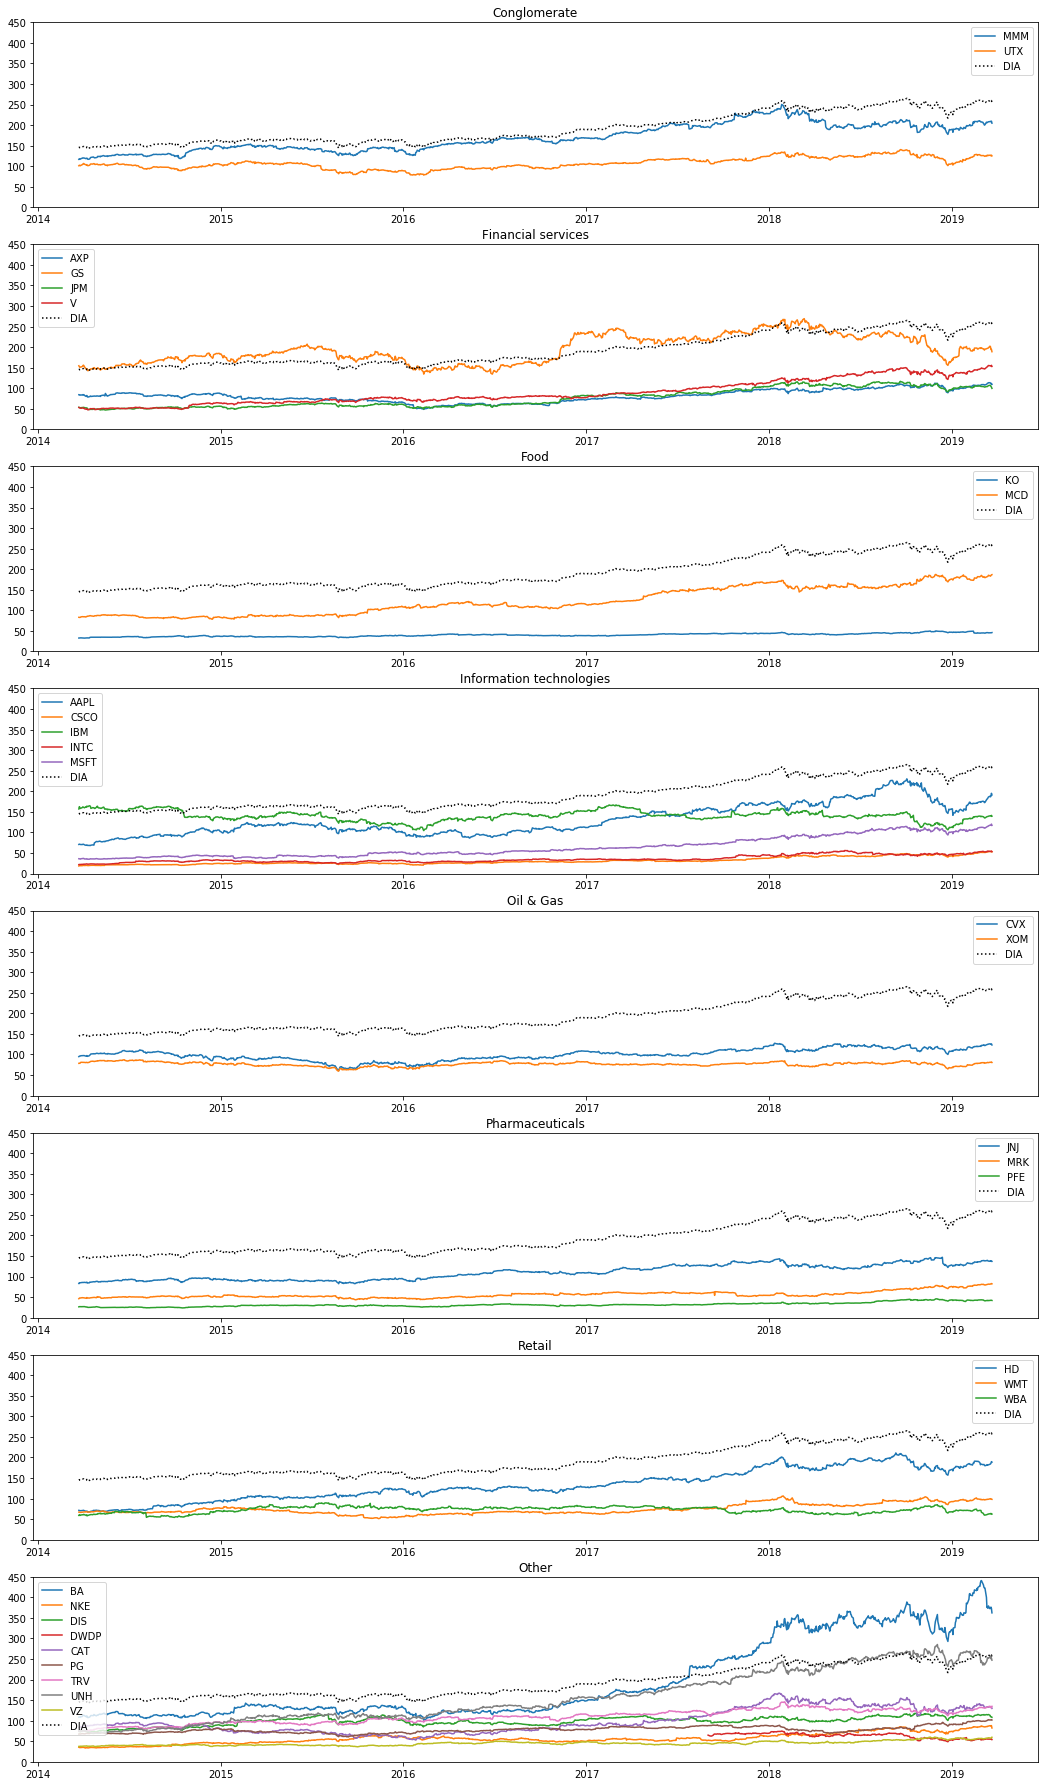

In [7]:
def plot_tickers_subset(subplot, title, ticker_symbols):
    for tkr in ticker_symbols:
        df = ds.getDataframe(ticker_symbol=tkr)
        subplot.plot(df.date, df.close, label=tkr)
    subplot.plot(dia_df.date, dia_df.close, label=Dataset.DJIA_SYMBOL, color='black', linestyle=':')
    subplot.legend()
    subplot.set_title(title)
    subplot.set_autoscale_on(False)
    subplot.set_ylim([0, plotting_y_value])

fig = plt.figure(figsize=(18, 32))

plot_tickers_subset(fig.add_subplot(811), 'Conglomerate', ['MMM', 'UTX'])
plot_tickers_subset(fig.add_subplot(812), 'Financial services', ['AXP', 'GS', 'JPM', 'V'])
plot_tickers_subset(fig.add_subplot(813), 'Food', ['KO', 'MCD'])
plot_tickers_subset(fig.add_subplot(814), 'Information technologies', ['AAPL', 'CSCO', 'IBM', 'INTC', 'MSFT'])
plot_tickers_subset(fig.add_subplot(815), 'Oil & Gas', ['CVX', 'XOM'])
plot_tickers_subset(fig.add_subplot(816), 'Pharmaceuticals', ['JNJ', 'MRK', 'PFE'])
plot_tickers_subset(fig.add_subplot(817), 'Retail', ['HD', 'WMT', 'WBA'])
plot_tickers_subset(fig.add_subplot(818),
                    'Other', ['BA', 'NKE', 'DIS', 'DWDP', 'CAT', 'PG', 'TRV', 'UNH', 'VZ'])

plt.plot()

In [ ]:
poc_df = dia_df.drop(['symbol', 'date'], axis=1)
#poc_df = dia_df.drop(['date'], axis=1)
#poc_df = poc_df.drop(['date'], axis=1)

pca = PCA(n_components = len(poc_df.columns)).fit(poc_df)

In [ ]:
pca_poc = pca.transform(poc_df)
print(pca_poc)
#pca_results = vs.pca_results(poc_df, pca)

In [ ]:
pca_results = pca_results(poc_df, pca)

# Trading days

In [ ]:
class TradingDaysHelper:
    """
    This is a helper to retrieve the days that the market is open.
    The market holidyas are loaded from a file, by default 'market_holidays.txt'.
    """

    def __init__(self, market_holidays_file='market_holidays.txt'):
        """
        The constructor.

        :param str market_holidays_file: The file containing the market holidays,
                                         by default 'market_holidays.txt'.
        """
        self.market_holidays = []

        with open(market_holidays_file) as f:
            lines = f.readlines()

        for line in lines:
            self.market_holidays.append(datetime.datetime.strptime(line.strip(), '%Y-%m-%d'))


    def __is_trading_day(self, day):
        """
        Verifies if in a particular day the market is open.

        :param datetime.datetime day: The day to verify if the marke is open.
        :return: True if the marke is open of False otherwise.
        :rtype: bool
        """
        day_of_week = day.weekday()
        if day_of_week == 5 or day_of_week == 6 or day in self.market_holidays:
            return False
        else:
            return True


    def get_trading_days_in_range(self, start_date, end_date):
        """
        Getting the trading days existing in a date range.

        :param datetime.datetime from_date: The starting date of the range.
        :param datetime.datetime to_date: The ending date of the range.
        :return: A list of the trading days in the specified date range.
        :rtype: list[datetime.datetime]
        """
        trading_days = []

        current_day = start_date
        while (current_day <= end_date):
            if self.__is_trading_day(current_day):
                trading_days.append(current_day)
            current_day += datetime.timedelta(days=1)

        return trading_days


    def get_trading_days_after(self, date, num_trading_days):
        """
        Getting a specific number of trading days after a given date.

        :param datetime.datetime date: The date after which training days are going to be retrieved.
        :param int num_trading_days: The number of training days to get.
        :return: A list containing the trading days.
        :rtype: list[datetime.datetime]
        """
        trading_days = []

        current_day = date
        while (len(trading_days) < num_trading_days):
            current_day += datetime.timedelta(days=1)
            if self.__is_trading_day(current_day):
                trading_days.append(current_day)

        return trading_days

# Models

In [ ]:
class StockForecasterModel:
    """
    This is a super-class to represent ML models/methods to perform predictions
    for the stock closing price for a particular company.
    """

    def __init__(self, ticker_symbol, trading_days_helper=None):
        """
        The constructor.

        :param str ticker_symbol: The ticker symbol to perform predictions for.
        :param trading_days_helper: The helper object to get the days that the market is open/closed.
        :type trading_days_helper: TradingDaysHelper or None
        """
        self.short_name = None
        self.long_name = None

        self.ticker_symbol = ticker_symbol

        self.training_start = None
        self.training_end = None

        if trading_days_helper is None:
            self.trading_days_helper = TradingDaysHelper()
        else:
            self.trading_days_helper = trading_days_helper


    def train(self, base_dataset, start_date=None, end_date=None):
        """
        Trains the model.

        :param Dataset base_dataset: The dataset used to extract the training set
                                     in accordance with the date range. 
        :param start_date: The minimum date for the records used in the training set.
        :type start_date: datetime.datetime or None
        :param end_date: The maximum date for the records used in the training set.
        :type end_date: datetime.datetime or None
        """
        raise NotImplementedError('Please Implement this method.')


    def predict(self, from_date, to_date=None, base_dataset=None):
        """
        Performs closing price predictions for a given date range.

        :param datetime.datetime from_date: The initial date of the date range to predict.
        :param to_date: The final date of the date range to predict.
        :type to_date: datetime.datetime or None
        :param base_dataset: The dataset used to support the prediction,
                             in case that the model supports that.
        :type base_dataset: Dataset or None
        """
        raise NotImplementedError('Please Implement this method.')


    @staticmethod
    def loadFromFile(file_name):
        """
        Loads the model from a file.

        :param str file_name: The name of the file to load the model from. 
        """
        with open(file_name, 'rb') as fp:
            return pickle.load(fp)


    def saveToFile(self, file_name=None):
        """
        Saves the current model to a file.

        :param file_name: The name of the file to save the model,
                          if None the data is saved to a file in the 'data' directory
                          using a name of the form 'model_name_ticker_yyyymmdd-yyyymmdd.pkl'
                          with the minimum and maximum dates used for training. 
        :type file_name: str or None
        :return: The name of the file used to store the model.
        :rtype: str
        """
        if file_name is None:
            file_name = os.path.join(
                'data',
                'model_{}_{}_{:%Y%m%d}-{:%Y%m%d}.pkl'.format(
                    self.short_name, self.ticker_symbol, self.training_start, self.training_end))

        with open(file_name, 'wb') as fp:
            pickle.dump(self, fp)

        return file_name

In [ ]:
class LinearRegressionStockForecaster(StockForecasterModel):
    """
    This represents a stock forecaster model based on linear regression.
    """

    def __init__(self, ticker_symbol, trading_days_helper=None):
        """
        The constructor.

        :param str ticker_symbol: The ticker symbol to perform predictions for.
        :param trading_days_helper: The helper object to get the days that the market is open/closed.
        :type trading_days_helper: TradingDaysHelper or None
        """
        StockForecasterModel.__init__(self, ticker_symbol, trading_days_helper=trading_days_helper)
        self.short_name = 'LinearRegression'
        self.long_name = 'Linear Regression'


    def train(self, base_dataset, start_date=None, end_date=None):
        """
        Trains the model.

        :param Dataset base_dataset: The dataset used to extract the training set
                                     in accordance with the date range. 
        :param start_date: The minimum date for the records used in the training set.
        :type start_date: datetime.datetime or None
        :param end_date: The maximum date for the records used in the training set.
        :type end_date: datetime.datetime or None
        """
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range.')

        training_set = base_dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                 from_date=start_date, to_date=end_date)

        self.training_start = min(training_set.date)
        self.training_end = max(training_set.date)

        x = training_set.drop(['symbol', 'date', 'close'], axis=1)
        y = training_set.close

        self.model = LinearRegression()
        self.model.fit(x, y)


    def predict(self, from_date, to_date=None, base_dataset=None):
        """
        Performs closing price predictions for a given date range.

        :param datetime.datetime from_date: The initial date of the date range to predict.
        :param to_date: The final date of the date range to predict.
        :type to_date: datetime.datetime or None
        :param base_dataset: This is not supported for this model.
        :type base_dataset: Dataset or None
        """
        if from_date is None:
            raise ValueError('Invalid initial date.')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict.')

        if base_dataset is not None:
            warnings.warn("Prediction using a base dataset is not supported.")

        # Getting the trading days in the predicting date range
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(from_date, to_date)

        x_train = datetime_array_to_dataframe(days_to_predict)
        expand_date_in_dataframe(x_train)
        x_train = x_train.drop(['date'], axis=1)

        y = self.model.predict(x_train)
        
        return pd.DataFrame({'symbol': self.ticker_symbol,
                             'date': days_to_predict,
                             'predicted_price': y})

In [ ]:
class ArimaStockForecaster(StockForecasterModel):
    """
    This represents a stock forecaster model based on Arima.
    """

    def __init__(self, ticker_symbol, trading_days_helper=None):
        """
        The constructor.

        :param str ticker_symbol: The ticker symbol to perform predictions for.
        :param trading_days_helper: The helper object to get the days that the market is open/closed.
        :type trading_days_helper: TradingDaysHelper or None
        """
        StockForecasterModel.__init__(self, ticker_symbol, trading_days_helper=trading_days_helper)
        self.short_name = 'Arima'
        self.long_name = 'Arima'


    def train(self, base_dataset, start_date=None, end_date=None):
        """
        Trains the model.

        :param Dataset base_dataset: The dataset used to extract the training set
                                     in accordance with the date range. 
        :param start_date: The minimum date for the records used in the training set.
        :type start_date: datetime.datetime or None
        :param end_date: The maximum date for the records used in the training set.
        :type end_date: datetime.datetime or None
        """
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range')

        training_set = base_dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                 from_date=start_date, to_date=end_date)
        self.training_start = min(training_set.date)
        self.training_end = max(training_set.date)

        training_set = training_set.close

        self.model = auto_arima(training_set,
                                start_p=1, start_q=1, max_p=3, max_q=3, m=12, start_P=0,
                                seasonal=True, d=1, D=1, trace=True,
                                error_action='ignore', suppress_warnings=True)
        self.model.fit(training_set)


    def predict(self, from_date, to_date=None, base_dataset=None):
        """
        Performs closing price predictions for a given date range.

        :param datetime.datetime from_date: The initial date of the date range to predict.
        :param to_date: The final date of the date range to predict.
        :type to_date: datetime.datetime or None
        :param base_dataset: This is not supported for this model.
        :type base_dataset: Dataset or None
        """
        if from_date is None:
            raise ValueError('Invalid initial date')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict')
        if from_date <= self.training_end:
            raise ValueError('Date range to predict should be after last date used for training')

        if base_dataset is not None:
            warnings.warn("Prediction using a base dataset is not supported.")

        # Getting the trading days to predict, including some gaps between the end of the training
        # and the begining of the prediction range
        prediction_start = self.training_end + datetime.timedelta(days=1)
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(prediction_start, to_date)

        y = self.model.predict(n_periods=len(days_to_predict))
        
        return pd.DataFrame({'symbol': self.ticker_symbol,
                             'date': days_to_predict,
                             'predicted_price': y}
                           )\
               .query("date >= '{}' and date <= '{}'".format(from_date, to_date))
               # Filtering to get just the days in the given prediction range

In [ ]:
class ProphetStockForecaster(StockForecasterModel):
    """
    This represents a stock forecaster model based on Facebook's Prophet.
    """
    
    def __init__(self, ticker_symbol, trading_days_helper=None):
        """
        The constructor.

        :param str ticker_symbol: The ticker symbol to perform predictions for.
        :param trading_days_helper: The helper object to get the days that the market is open/closed.
        :type trading_days_helper: TradingDaysHelper or None
        """
        StockForecasterModel.__init__(self, ticker_symbol, trading_days_helper=trading_days_helper)
        self.short_name = 'Prophet'
        self.long_name = 'Prophet'


    def train(self, base_dataset, start_date=None, end_date=None):
        """
        Trains the model.

        :param Dataset base_dataset: The dataset used to extract the training set
                                     in accordance with the date range. 
        :param start_date: The minimum date for the records used in the training set.
        :type start_date: datetime.datetime or None
        :param end_date: The maximum date for the records used in the training set.
        :type end_date: datetime.datetime or None
        """
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range')

        self.training_set = base_dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                      from_date=start_date, to_date=end_date)
        self.training_start = min(self.training_set.date)
        self.training_end = max(self.training_set.date)

        self.training_set = pd.DataFrame(self.training_set, columns=['date', 'close'])
        self.training_set.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

        self.model = Prophet(daily_seasonality=True)
        self.model.fit(self.training_set)


    def predict(self, from_date, to_date=None, base_dataset=None):
        """
        Performs closing price predictions for a given date range.

        :param datetime.datetime from_date: The initial date of the date range to predict.
        :param to_date: The final date of the date range to predict.
        :type to_date: datetime.datetime or None
        :param base_dataset: This is not supported for this model.
        :type base_dataset: Dataset or None
        """
        if from_date is None:
            raise ValueError('Invalid initial date')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict')
        if from_date <= self.training_end:
            raise ValueError('Date range to predict should be after last date used for training')

        if base_dataset is not None:
            warnings.warn("Prediction using a base dataset is not supported.")

        # Getting the trading days to predict, including some gaps between the end of the training
        # and the begining of the prediction range
        prediction_start = self.training_end + datetime.timedelta(days=1) 
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(prediction_start, to_date)

        x = self.model.make_future_dataframe(periods=len(days_to_predict))
        y = self.model.predict(x)['yhat'][self.training_set.shape[0]:]

        return pd.DataFrame({'symbol': self.ticker_symbol,
                             'date': days_to_predict,
                             'predicted_price': y})\
               .query("date >= '{}' and date <= '{}'".format(from_date, to_date))
               # Filtering to get just the days in the given prediction range

In [ ]:
class LongShortTermMemoryStockForecaster(StockForecasterModel):
    """
    This represents a stock forecaster model based Long Short Term Memory
    (with Recurrent Neural Networks).
    """

    def __init__(self, ticker_symbol, trading_days_helper=None, timesteeps=60, training_epocs=2):
        """
        The constructor.

        :param str ticker_symbol: The ticker symbol to perform predictions for.
        :param trading_days_helper: The helper object to get the days that the market is open/closed.
        :type trading_days_helper: TradingDaysHelper or None
        """
        StockForecasterModel.__init__(self, ticker_symbol, trading_days_helper=trading_days_helper)
        self.short_name = 'LSTM'
        self.long_name = 'Long Short Term Memory'
        self.scaler = MinMaxScaler(feature_range=(0, 1))
        self.timesteeps = timesteeps
        self.training_epocs = training_epocs


    def train(self, base_dataset, start_date=None, end_date=None):
        """
        Trains the model.

        :param Dataset base_dataset: The dataset used to extract the training set
                                     in accordance with the date range. 
        :param start_date: The minimum date for the records used in the training set.
        :type start_date: datetime.datetime or None
        :param end_date: The maximum date for the records used in the training set.
        :type end_date: datetime.datetime or None
        """
        if start_date is not None and end_date is not None and start_date > end_date:
            raise ValueError('Invalid training date range')

        self.training_set = base_dataset.getDataframe(ticker_symbol=self.ticker_symbol,
                                                      from_date=start_date, to_date=end_date)
        self.training_start = min(self.training_set.date)
        self.training_end = max(self.training_set.date)
        self.training_set = pd.DataFrame(self.training_set, columns=['close'])
        scaled_training_set = self.scaler.fit_transform(self.training_set)

        x_train, y_train = [], []
        for i in range(self.timesteeps, len(scaled_training_set)):
            x_train.append(scaled_training_set[i - self.timesteeps : i, 0])
            y_train.append(scaled_training_set[i, 0])

        x_train, y_train = np.array(x_train), np.array(y_train)
        x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

        # Creating and fitting the LSTM network
        self.model = Sequential()
        self.model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
        self.model.add(LSTM(units=50))
        self.model.add(Dense(1))

        self.model.compile(loss='mean_squared_error', optimizer='adam')
        self.model.fit(x_train, y_train, epochs=self.training_epocs, batch_size=1, verbose=2)


    def predict(self, from_date, to_date=None, base_dataset=None):
        """
        Performs closing price predictions for a given date range.

        :param datetime.datetime from_date: The initial date of the date range to predict.
        :param to_date: The final date of the date range to predict.
        :type to_date: datetime.datetime or None
        :param base_dataset: The dataset used to support the prediction.
        :type base_dataset: Dataset or None
        """
        if from_date is None:
            raise ValueError('Invalid initial date')
        if to_date is None:
            to_date = from_date
        if from_date > to_date:
            raise ValueError('Invalid date range to predict')
        if from_date <= self.training_end:
            raise ValueError('Date range to predict should be after last date used for training')

        # Getting the trading days to predict, including some gaps between the end of the training
        # and the begining of the prediction range
        prediction_start = self.training_end + datetime.timedelta(days=1) 
        days_to_predict = self.trading_days_helper.get_trading_days_in_range(prediction_start, to_date)

        if base_dataset is not None:
            inputs = base_dataset.dataframe.query(
                "symbol == '{}' and date >= '{}' and date <= '{}'"\
                .format(self.ticker_symbol, self.training_start, self.training_end))\
                .close.values
        else:
            inputs = self.training_set.close.values
        
        inputs = inputs[len(inputs) - self.timesteeps:]
        #inputs = self.training_set.close[len(self.training_set) - self.timesteeps:].values
        inputs = inputs.reshape(-1,1)
        inputs = self.scaler.transform(inputs).reshape(-1)

        y = []

        for i in range(0, len(days_to_predict)):
            x = np.array(inputs[i : i + self.timesteeps])
            x = np.reshape(x, (1, self.timesteeps, 1))

            pred = self.model.predict(x)
            y.append(self.scaler.inverse_transform(pred).reshape(-1)[0])

            existing_rec = base_dataset.dataframe.query(
                "date == '{}' and symbol == '{}'".format(days_to_predict[i], self.ticker_symbol)) \
                if base_dataset is not None else None
            if existing_rec is not None and len(existing_rec) > 0:
                inputs = np.append(
                    inputs, self.scaler.transform(existing_rec.close.values.reshape(-1,1)).reshape(-1)[0])
            else:
                inputs = np.append(inputs, pred)

        return pd.DataFrame({'symbol': self.ticker_symbol,
                             'date': days_to_predict,
                             'predicted_price': y})\
               .query("date >= '{}' and date <= '{}'".format(from_date, to_date))
               # Filtering to get just the days in the given prediction range

# Performance Measurement

In [ ]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [ ]:
def get_training_and_validation_sets(dataset, trading_days_helper,
                                     ticker_symbol, training_start, training_end, validation_days):
    validation_trading_days = trading_days_helper.get_trading_days_after(training_end, max(validation_days))
    validation_start = min(validation_trading_days)
    validation_end = max(validation_trading_days)

    training_ds = dataset.getSubset(ticker_symbol=ticker_symbol,
                                    from_date=training_start, to_date=training_end)    
    validation_ds = dataset.getSubset(ticker_symbol=ticker_symbol,
                                      from_date=validation_start, to_date=validation_end)

    return training_ds, validation_ds


def measure_performance(results, subplot, title, model,
                        base_dataset, training_dataset, validation_dataset, validation_days):
    validation_start = min(validation_dataset.dataframe.date)
    validation_end = max(validation_dataset.dataframe.date)

    preds = model.predict(validation_start, to_date=validation_end, base_dataset=base_dataset)

    for v in validation_days:
        results.append({'method': title,
                        'symbol': ticker_symbol,
                        'forecasting_days': v,
                        'RMSE': rmse(preds.predicted_price.values[:v],
                                     validation_ds.dataframe.close.values[:v])})

    subplot.plot(training_dataset.dataframe.date, training_dataset.dataframe.close, label='Training')
    subplot.plot(validation_dataset.dataframe.date, validation_dataset.dataframe.close, label='Validation')
    subplot.plot(preds.date, preds.predicted_price, label='Prediction')
    subplot.set_title(title)
    subplot.legend()

    return results


def create_train_and_save_model(name, model_constructor, ticker_symbol,
                                training_dataset, training_start, training_end,
                                trading_days_helper):
    file_name = os.path.join('data_analysis', name + '.pkl')

    model = model_constructor(ticker_symbol, trading_days_helper=trading_days_helper)
    model.train(training_dataset, training_start, training_end)
    model_file = model.saveToFile(file_name)

    return file_name

# POCs

In [ ]:
ds = Dataset.loadDatasetFromFile(os.path.join('data', 'djia_20140303-20190315.pkl'))
ds.updateData()
dataset_filename = ds.saveDataToFile()

In [ ]:
ds = Dataset.loadDatasetFromFile(dataset_filename)

In [ ]:
trading_days_helper = TradingDaysHelper()

ticker_symbol = 'AAPL'
training_start = str_to_datetime('2015-04-01')
training_end = str_to_datetime('2018-03-31')
validation_days = [1, 5, 10, 20, 40, 60, 120]

training_ds, validation_ds = get_training_and_validation_sets(
    ds, trading_days_helper, ticker_symbol, training_start, training_end, validation_days)

training_and_validation_ds = Dataset(pd.concat([training_ds.dataframe, validation_ds.dataframe]))

In [ ]:
linear_regresion_model_file = create_train_and_save_model(
    'Analisys_1_LinearRegression', LinearRegressionStockForecaster,
    ticker_symbol, training_ds, training_start, training_end, trading_days_helper)

In [ ]:
arima_model_file = create_train_and_save_model(
    'Analisys_1_Arima', ArimaStockForecaster,
    ticker_symbol, training_ds, training_start, training_end, trading_days_helper)

In [ ]:
prophet_model_file = create_train_and_save_model(
    'Analisys_1_Prophet', ProphetStockForecaster,
    ticker_symbol, training_ds, training_start, training_end, trading_days_helper)

In [ ]:
lstm_model_file = create_train_and_save_model(
    'Analisys_1_LSTM', LongShortTermMemoryStockForecaster,
    ticker_symbol, training_ds, training_start, training_end, trading_days_helper)

In [ ]:
linear_regresion_model = StockForecasterModel.loadFromFile(linear_regresion_model_file)
arima_model = StockForecasterModel.loadFromFile(arima_model_file)
prophet_model = StockForecasterModel.loadFromFile(prophet_model_file)
lstm_model = StockForecasterModel.loadFromFile(lstm_model_file)

In [ ]:
results = []

fig = plt.figure(figsize=(18, 20))
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)

measure_performance(results, ax1, linear_regresion_model.long_name, linear_regresion_model,
                    None, training_ds, validation_ds, validation_days)
measure_performance(results, ax2, arima_model.long_name, arima_model,
                    None, training_ds, validation_ds, validation_days)
measure_performance(results, ax3, prophet_model.long_name, prophet_model,
                    None, training_ds, validation_ds, validation_days)
measure_performance(results, ax4, lstm_model.long_name, lstm_model,
                    None, training_ds, validation_ds, validation_days)
measure_performance(results, ax5, lstm_model.long_name + ' - daily prediction', lstm_model,
                    training_and_validation_ds, training_ds, validation_ds, validation_days)

plt.show()

In [ ]:
results_df = pd.DataFrame(columns = ['method', 'symbol', 'forecasting_days', 'RMSE'], data = results)
results_df = results_df.pivot(index='method', columns='forecasting_days', values='RMSE')

#results_df.columns.name = None
#results_df = results_df.reset_index()

print(results_df)